In [64]:
import pandas as pd
import numpy as np
import os
import sys
import json
from pathlib import Path
import matplotlib.pyplot as plt
from tueplots import bundles
import tueplots.constants.color.rgb as rgb

BASE_DIR = Path.cwd().parent.parent
DATA_DIR = os.path.join(BASE_DIR, "data", "data_final")
CSV_PATH = os.path.join(BASE_DIR, "data", "data_final", "final_dataset.csv")
NOVELTY_PATH = os.path.join(DATA_DIR, "knn_faiss_novelty.csv")
IMDB_RATINGS_PATH = os.path.join(DATA_DIR, "title_ratings.tsv")
OSCAR_NOMINATIONS_PATH = os.path.join(DATA_DIR, "oscar-nominations.json")

CUSTOM_ORANGE = (1.0, 95 / 255, 31 / 255)
CUSTOM_LIGHTORANGE = (1.0, 142 / 255, 98 / 255)
CUSTOM_LIGHTBLUE = (85 / 255, 190 / 255, 255 / 255)

sys.path.insert(0, str(BASE_DIR))

plt.rcParams.update(bundles.icml2024(column="half", nrows=1, ncols=1))

from src.utils.data_utils import load_final_data_with_embeddings

In [2]:
df = load_final_data_with_embeddings(CSV_PATH, DATA_DIR)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92374 entries, 0 to 92373
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   movie_id                       92374 non-null  object 
 1   country                        91534 non-null  object 
 2   imdb_id                        91006 non-null  object 
 3   duration                       57734 non-null  float64
 4   duration_all                   57734 non-null  object 
 5   actors_id                      75496 non-null  object 
 6   actors                         75496 non-null  object 
 7   directors_id                   86598 non-null  object 
 8   directors                      86598 non-null  object 
 9   genre_id                       80918 non-null  object 
 10  genre                          80884 non-null  object 
 11  release_date                   92374 non-null  object 
 12  wikidata_class                 92374 non-null 

In [84]:
oscar_nominations_dict = json.load(open(OSCAR_NOMINATIONS_PATH, 'r'))
best_original_screenplay_nominations_imdb_ids = [
    movie["imdb_id"]
    for nomination in oscar_nominations_dict
    if nomination["category"] == "Best Original Screenplay"
    for movie in nomination["movies"]
]
# Add nominations from 2024 because they are missing in the json file
best_original_screenplay_nominations_imdb_ids += [
    "tt28607951", # Anora
    "tt8999762", # Brutalist
    "tt21823606", # A Real Pain
    "tt28082769", # September 5
    "tt17526714", # The Substance
]

df['oscar_best_original_screenplay_nominee'] = df['imdb_id'].isin(best_original_screenplay_nominations_imdb_ids)

/tmp/ipykernel_64049/3188403728.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


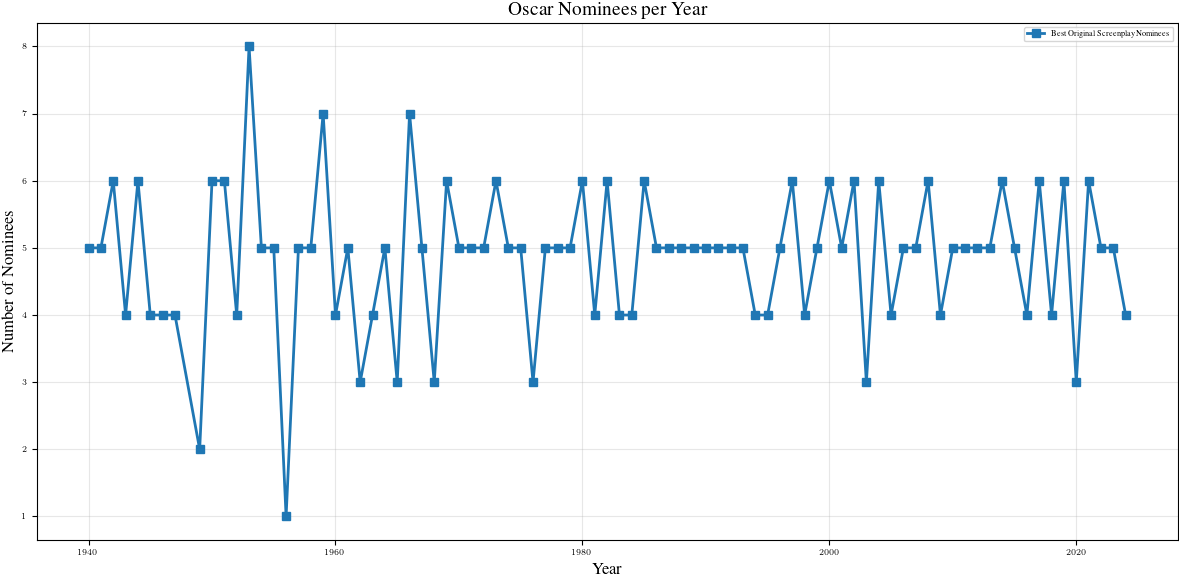

In [85]:
best_original_screenplay_nominees_per_year = df[df['oscar_best_original_screenplay_nominee']].groupby('year').size()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(best_original_screenplay_nominees_per_year.index, best_original_screenplay_nominees_per_year.values, 
    marker='s', label='Best Original Screenplay Nominees', linewidth=2)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Nominees', fontsize=12)
ax.set_title('Oscar Nominees per Year', fontsize=14)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
knn_results = pd.read_csv(NOVELTY_PATH)
knn_results["neighbor_distances"] = knn_results["neighbor_distances"].apply(lambda x: json.loads(x))
knn_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92374 entries, 0 to 92373
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   movie_id            92374 non-null  object
 1   neighbor_ids        92374 non-null  object
 2   neighbor_distances  92374 non-null  object
dtypes: object(3)
memory usage: 2.1+ MB


In [7]:
knn_results["novelty_score"] = knn_results["neighbor_distances"].apply(lambda x: x[0])
df = df.merge(knn_results[["movie_id", "novelty_score"]], on="movie_id", how="left")

/tmp/ipykernel_64049/3809129334.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter_all = ax.scatter(valid_data['year'], valid_data['novelty_score'],
/tmp/ipykernel_64049/3809129334.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter_oscar = ax.scatter(nominees['year'], nominees['novelty_score'],
/tmp/ipykernel_64049/3809129334.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


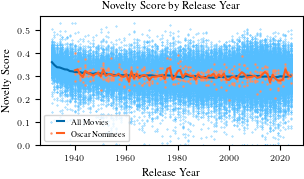

In [103]:
from matplotlib.legend_handler import HandlerTuple
valid_data = df[df['novelty_score'] >= 0].copy()

yearly_avg_oscar = valid_data[valid_data['oscar_best_original_screenplay_nominee']].groupby('year')['novelty_score'].mean()
yearly_avg = valid_data.groupby('year')['novelty_score'].mean()
yearly_std = valid_data.groupby('year')['novelty_score'].std()

fig, ax = plt.subplots()
scatter_all = ax.scatter(valid_data['year'], valid_data['novelty_score'],
           c=CUSTOM_LIGHTBLUE, marker='o', s=0.1)

nominees = valid_data[valid_data['oscar_best_original_screenplay_nominee']]
scatter_oscar = ax.scatter(nominees['year'], nominees['novelty_score'], 
           c=CUSTOM_LIGHTORANGE, marker='o', s=0.5, linewidths=None)

line_all, = ax.plot(yearly_avg.index, yearly_avg.values, 
        color=rgb.tue_blue, linestyle='-')
line_oscar, = ax.plot(yearly_avg_oscar.index, yearly_avg_oscar.values, 
        color=CUSTOM_ORANGE, linestyle='-')
# Erro bars look a bit bad
# ax.errorbar(
#     yearly_avg.index, yearly_avg.values, 
#     yerr=yearly_std.values, fmt='none', ecolor=rgb.tue_blue, alpha=0.3
# )

# fig.suptitle('Novelty Score by Year')
ax.set_title('Novelty Score by Release Year')
ax.set_xlabel("Release Year")
ax.set_ylabel('Novelty Score')
ax.legend(
    handles=[(scatter_all, line_all), (scatter_oscar, line_oscar)],
    labels=['All Movies', 'Oscar Nominees'],
    
    # This tells matplotlib to draw the tuple elements side-by-side
    handler_map={tuple: HandlerTuple(ndivide=None)}, 
    
    loc='best',
)
ax.set_ylim(bottom=0.0)

plt.tight_layout()
plt.savefig(
    Path(os.path.abspath("")).parent.parent / "report" / "figures" / "oscar_novelty_scatter.pdf",
    bbox_inches="tight"
)
plt.show()

In [102]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(
    yearly_avg.index, yearly_avg.values
)
print(f"Slope: {round(slope, 6)}, Intercept: {intercept}, R-squared: {round(r_value**2, 2)}, P-value: {p_value}, Std Err: {std_err}")

Slope: -0.000331, Intercept: 0.958924747710751, R-squared: 0.56, P-value: 5.83469112656866e-18, Std Err: 3.0777264805906004e-05


In [101]:
differenece_avgs = yearly_avg - yearly_avg_oscar
differenece_avgs.dropna(inplace=True)

absolute_differences = np.abs(differenece_avgs)
mean_absolute_difference = absolute_differences.mean()
std_absolute_difference = absolute_differences.std()
print(f"Mean Absolute Difference between yearly averages: {round(mean_absolute_difference, 4)}")
print(f"Std Dev of Absolute Difference between yearly averages: {round(std_absolute_difference, 4)}")

Mean Absolute Difference between yearly averages: 0.0098
Std Dev of Absolute Difference between yearly averages: 0.008


In [105]:
from scipy.stats import ttest_rel
t_stat, p_value = ttest_rel(
    yearly_avg.loc[differenece_avgs.index],
    yearly_avg_oscar.loc[differenece_avgs.index]
)
print(f"Paired t-test: t-statistic = {round(t_stat, 4)}, p-value = {round(p_value, 4)}")

Paired t-test: t-statistic = -0.5269, p-value = 0.5997
